In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

In [4]:
optim_fn2label = {
    ackley: 'Ackley',
    rastrigin: 'Rastrigin',
    rosenbrock: 'Rosenbrock',
    sphere: 'Sphere',
    lin_fn: 'Linear',
}

In [52]:
from paper_meta import *

In [12]:
algos = algos_all

In [13]:
optim_fns = [ackley, rastrigin, rosenbrock, sphere, lin_fn]
n_dims = [2, 30, 100, 1000]
# init_pop_vars = [.1, 1, 5, 10]
init_pop_vars = [1, 10]
n_seed = 5
n_gen = 500
n_pop = 101

data = np.empty((len(algos), len(optim_fns), len(n_dims), 
                 len(init_pop_vars), n_seed, 4), dtype=object)
data = xr.DataArray(data, dims=('algo', 'optim_fn', 'n_dim', 
                                'init_pop_var', 'seed', 'fits_mrs'),
                    coords={'algo': algos, 
                            'optim_fn': optim_fns,
                            'n_dim': n_dims,
                            'init_pop_var': init_pop_vars,
                            'seed': list(range(n_seed)),
                            'fits_mrs': ['fits', 'mrs', 'best_fit', 'avg_fit'],
                           })

pbar = tqdm(total=len(optim_fns)*len(n_dims)*len(init_pop_vars)*n_seed*len(algos))
for optim_fn in optim_fns:
    for n_dim in [1000, 100, 30, 2]:
        for init_pop_var in init_pop_vars:
            for seed in range(n_seed):
                do_seed(seed)
                pop = torch.randn(n_pop, n_dim)*init_pop_var
                for algo in algos:
                    if optim_fn==lin_fn:
                        n_gen = 100
                    elif n_dim==2:
                        n_gen = 100
                    elif n_dim==30:
                        n_gen = 300
                    elif n_dim==100:
                        n_gen = 500
                    elif n_dim==1000:
                        n_gen = 2000
                    res = algo2algo_fn[algo](pop, optim_fn, n_gen)
                    pops, fits, mrs = res[:3]
                    fits = fits.min(dim=-1).values
                    while mrs.ndim>1:
                        mrs = mrs.log().mean(dim=-1).exp()
                    
                    a = data.sel(algo=algo, optim_fn=optim_fn, n_dim=n_dim, 
                                 init_pop_var=init_pop_var, seed=seed)
#                     print(a[0].data)
                    a.data[0] = fits.detach().cpu().numpy()
#                     print(a[0].data)
                    a.data[1] = mrs.detach().cpu().numpy()
                    a.data[2] = fits.min().item()
                    a.data[3] = fits.mean().item()
                    
                    pbar.update(n=1); pbar.refresh()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
torch.save(data, 'results/main_data.th')

In [8]:
data = torch.load('data/main_data.th')
a = np.array(algos)[data.sel(gen=500, fits_mrs='fits').argmin(dim='algo').data]

AttributeError: Can't get attribute 'PandasIndex' on <module 'xarray.core.indexes' from '/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/xarray/core/indexes.py'>

In [16]:
def get_latex_data_str(data, auc=False, show_std=False, bold_best=True):
    s = ''
    # for optim_fn in [ackley, rastrigin, rosenbrock, sphere, lin_fn]:
    for optim_fn in [ackley, rastrigin, rosenbrock, sphere]:
#         print(optim_fn)
#     for optim_fn in [ackley]:
        s += '\multirow{8}{*}{\\rotatebox[origin=c]{90}{'+optim_fn2label[optim_fn]+'}}\n'
        for n_dim in [2, 30, 100, 1000]:
            s += ' &\multirow{2}{*}{'+str(n_dim)+'}\n'
            for i, init_pop_var in enumerate([1, 10]):
                s += '&' if i>0 else ' '
                s += f'& {init_pop_var:2.1f}\n'
                datai = data.sel(optim_fn=optim_fn, n_dim=n_dim, 
                                 init_pop_var=init_pop_var)
                if auc:
                    datai = datai.sel(fits_mrs='avg_fit').astype(np.float32)
                else:
                    datai = datai.sel(fits_mrs='best_fit').astype(np.float32)
                algos_sorted = np.array(algos)[datai.mean(dim='seed').argsort().data]
                best_algo = [a for a in algos_sorted if a not in algos_oracle][0]
                
                pvals = []
                for algo in subtract_list(algos_normal, [best_algo]):
                    other = datai.sel(algo=algo).data
                    ours = datai.sel(algo=best_algo).data
                    pval = scipy.stats.ttest_ind(other, ours).pvalue
                    pvals.append(pval)
#                     print(other.mean(), ours.mean(), pval, pval<0.05)
                is_significant = (np.array(pvals)<0.05).all()
                for algo in algos:
                    mean = datai.sel(algo=algo).mean().data
                    std = datai.sel(algo=algo).std().data
                    
                    datai_str = f'{mean:1.02e}'
                    if show_std:
                        datai_str = datai_str + f' $\pm$ {std:1.02e}'
                    
                    if bold_best and algo==best_algo:
                        datai_str = '\\textbf{'+f'{datai_str}'+'}'
                        if is_significant:
                            datai_str = '*'+datai_str+'*'
                        
                    s += f' & {datai_str}'
                        
                s += '\\\\\n'
        s += '\\hline\n'
    return s
print(get_latex_data_str(data, auc=False, show_std=False, bold_best=True))

\multirow{8}{*}{\rotatebox[origin=c]{90}{Ackley}}
 &\multirow{2}{*}{2}
 & 1.0
 & 3.04e-04 & 2.05e-03 & 2.85e-02 & 8.61e-03 & 1.99e-02 & 2.16e-02 & \textbf{0.00e+00} & 7.10e-05 & 2.29e-04 & 5.88e-04\\
&& 10.0
 & 7.18e-01 & 4.13e-03 & 2.64e-02 & 9.72e-02 & 6.80e-02 & 3.28e-02 & 7.15e-01 & \textbf{1.50e-02} & 7.15e-01 & 2.87e+00\\
 &\multirow{2}{*}{30}
 & 1.0
 & 1.42e+00 & 3.42e-02 & 2.46e+00 & \textbf{5.62e-01} & 2.61e+00 & 2.32e+00 & 2.13e+00 & 7.33e-01 & 3.09e+00 & 2.59e+00\\
&& 10.0
 & 2.51e+00 & 8.24e-01 & 1.51e+01 & 2.72e+00 & 2.41e+00 & 4.48e+00 & 1.11e+01 & *\textbf{9.96e-01}* & 1.54e+01 & 1.50e+01\\
 &\multirow{2}{*}{100}
 & 1.0
 & 2.92e+00 & 2.58e+00 & 2.96e+00 & \textbf{2.56e+00} & 3.01e+00 & 3.31e+00 & 2.79e+00 & 2.57e+00 & 3.97e+00 & 2.96e+00\\
&& 10.0
 & 6.07e+00 & 3.96e+00 & 1.64e+01 & 7.28e+00 & 7.45e+00 & 8.42e+00 & 1.59e+01 & *\textbf{4.46e+00}* & 1.74e+01 & 1.64e+01\\
 &\multirow{2}{*}{1000}
 & 1.0
 & 3.75e+00 & 3.54e+00 & 4.74e+00 & \textbf{3.65e+00} & 4.19e+00 & 4.16e

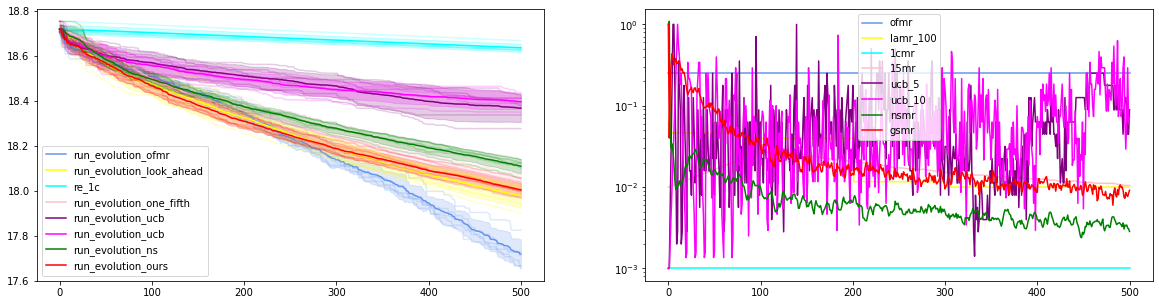

In [99]:
# algos_render = ['ofmr', 'lamr_100', '15mr', 'ucb_5', 'nsmr', 'gsmr']
plt.figure(figsize=(20,5))
plt.subplot(121)
for algo in algos:
    label = algo2algo_fn[algo]
    if type(algo2algo_fn[algo])==partial:
        label = label.func
    label = label.__name__
    a = data.sel(algo=algo, optim_fn=ackley, n_dim=1000, init_pop_var=10, fits_mrs='fits')
    viz.plot_mean_std(torch.from_numpy(a.data), label, algo2color[algo], False, 
                      render_mean=True, render_std=True, render_plots=True)
plt.subplot(122)
for algo in algos:
    label = algo
    a = data.sel(algo=algo, optim_fn=ackley, n_dim=1000, init_pop_var=10, fits_mrs='mrs')
    viz.plot_mean_std(torch.from_numpy(a.data), label, algo2color[algo], True, 
                      render_mean=True, render_std=False, render_plots=False)

In [73]:
np.stack(data.sel(algo=algo, optim_fn=optim_fn, n_dim=100, init_pop_var=10, fits_mrs='fits').data)

array([[17.448181, 17.448181, 17.39843 , 17.39843 , 17.317276, 17.31382 ,
        17.262516, 17.262516, 17.15335 , 17.136614, 17.113129],
       [18.159086, 18.084314, 18.023952, 18.023952, 17.984983, 17.84944 ,
        17.84944 , 17.84944 , 17.841549, 17.841549, 17.840109],
       [17.959038, 17.933502, 17.92569 , 17.92569 , 17.897335, 17.818556,
        17.818556, 17.700624, 17.700624, 17.700624, 17.526688],
       [17.916145, 17.916145, 17.893456, 17.893456, 17.779818, 17.779818,
        17.779818, 17.779818, 17.732876, 17.67646 , 17.658123],
       [17.753952, 17.753952, 17.692104, 17.600037, 17.600037, 17.497982,
        17.497982, 17.497982, 17.46274 , 17.382965, 17.288404]],
      dtype=float32)

In [ ]:
# algos_render = ['ofmr', 'lamr_100', '15mr', 'ucb_5', 'nsmr', 'gsmr']
optim_fns_render = [ackley, rastrigin, sphere, lin_fn]
fig, axs = plt.subplots(len(optim_fns_render), 2, figsize=(20,5*len(optim_fns_render)))
ax = fig.add_subplot(1, 2, 1); viz.empty_ax(ax)
plt.ylabel('Function Value, $f(x)$', fontsize=35, labelpad=25)
ax = fig.add_subplot(1, 2, 2); viz.empty_ax(ax)
plt.ylabel('Mutation Rate, $\sigma$', fontsize=35, labelpad=25)
ax = fig.add_subplot(1, 1, 1); viz.empty_ax(ax)
plt.xlabel('Generation', fontsize=35, labelpad=20)

for i, optim_fn in enumerate(optim_fns_render):
    algos_render = ['ofmr', 'lamr_100', 'nsmr', 'gsmr']
    algos_render = subtract_list(algos, algos_oracle)+algos_oracle
    plt.sca(axs[i, 0])
    plt.title(optim_fn2label[optim_fn], fontsize=25)
#     plt.ylabel('Function Value, $f(x)$', fontsize=25)
#     plt.locator_params(axis='y', nbins=5)
    plt.xticks(fontsize=15); plt.yticks(fontsize=15)
    plt.grid()
    for algo in algos_render:
        a = np.stack(data.sel(algo=algo, optim_fn=optim_fn, n_dim=100, init_pop_var=10, fits_mrs='fits').data).copy()
        viz.plot_mean_std(torch.from_numpy(a), algo2label[algo], algo2color[algo], False, 
                          render_mean=True, render_std=True, render_plots=False, use_std_error=True, linewidth=3)
        plt.legend().remove()
    plt.yscale('symlog')
    
#     ticks = plt.gca().get_yticks()
#     if len(ticks)>7: 
#         plt.gca().set_yticks(ticks[::len(ticks)//2])
    
    plt.sca(axs[i, 1])
    plt.title(optim_fn2label[optim_fn], fontsize=25)
#     plt.ylabel('Mutation Rate, $\sigma$', fontsize=25)
    plt.grid()
    for algo in algos_render:
        a = np.stack(data.sel(algo=algo, optim_fn=optim_fn, n_dim=100, init_pop_var=10, fits_mrs='mrs').data).copy()
        viz.plot_mean_std(torch.from_numpy(a), algo2label[algo], algo2color[algo], True, 
                          render_mean=True, render_std=False, render_plots=False, use_std_error=True, linewidth=3)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend().remove()
    
    plt.xticks(fontsize=15); plt.yticks(fontsize=15)
ax.legend(handles, labels, fontsize=27, ncol=5, bbox_to_anchor=(1., 1.15))

plt.tight_layout()

plt.savefig('results/fits_mrs_test.png', dpi=300, bbox_inches='tight')
plt.show()

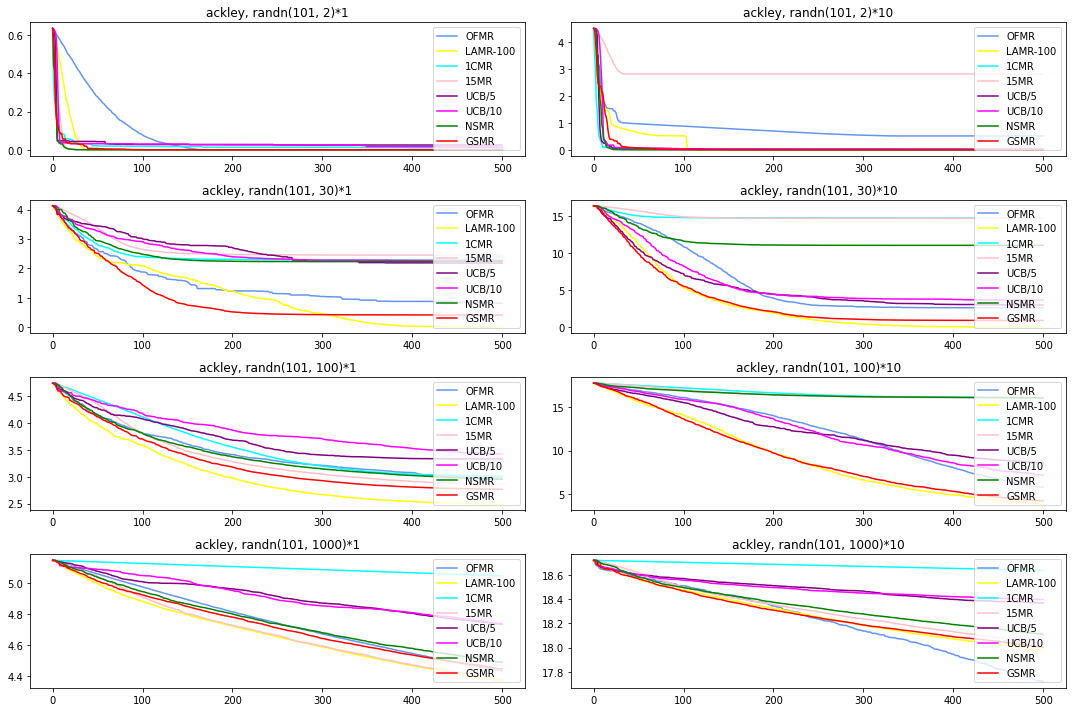

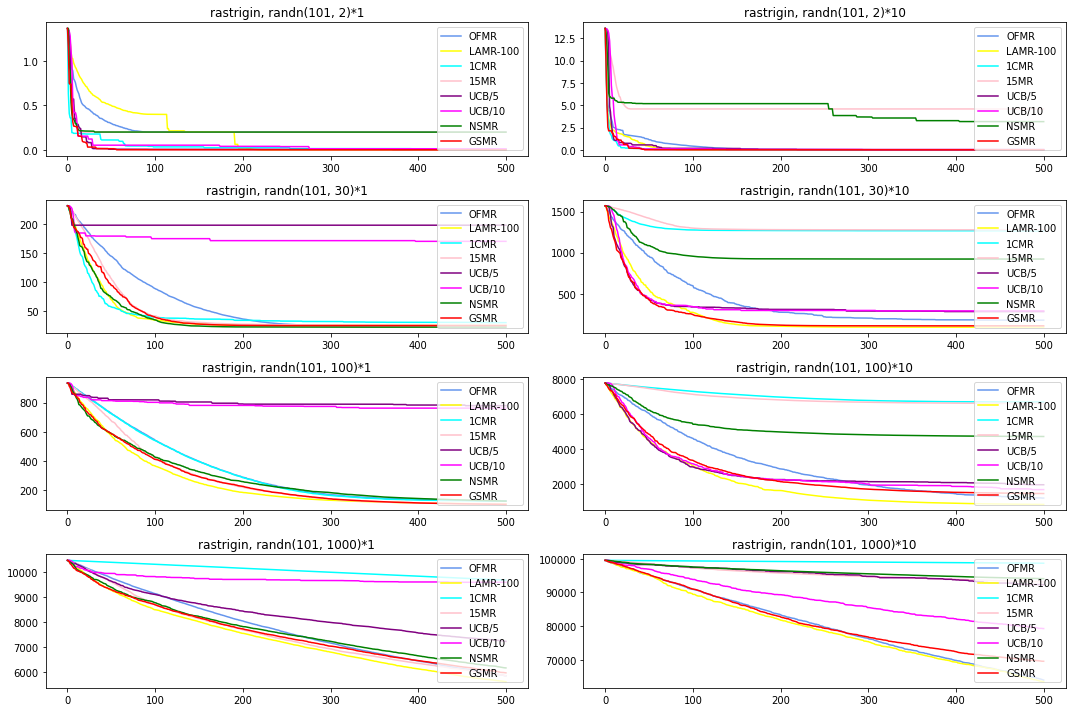

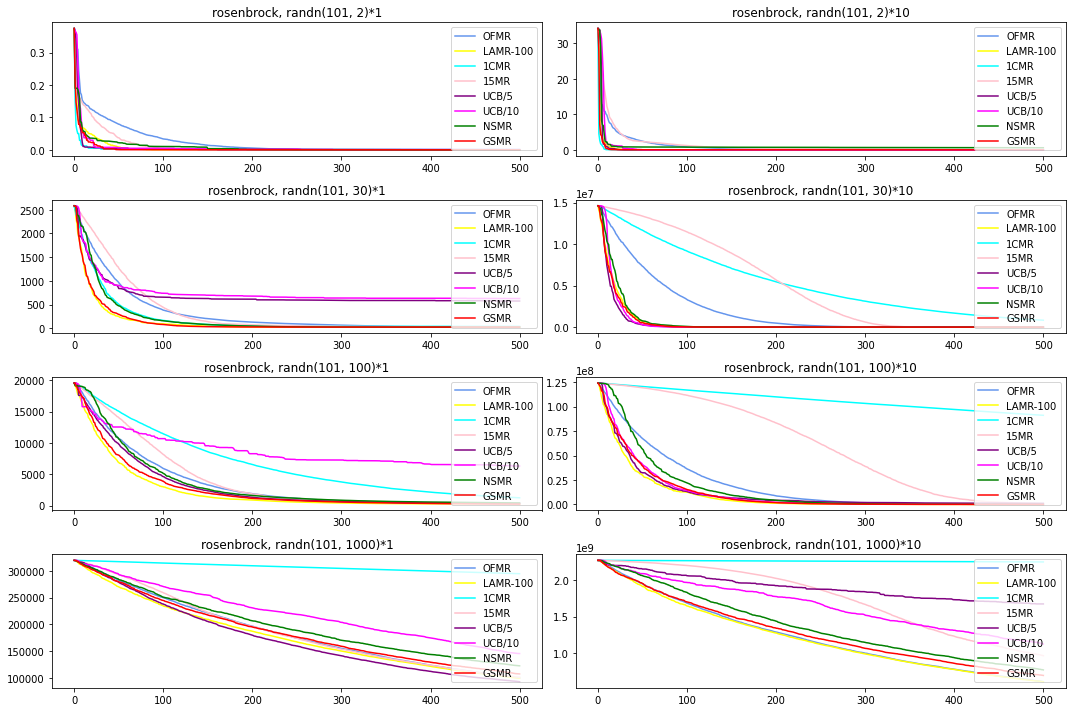

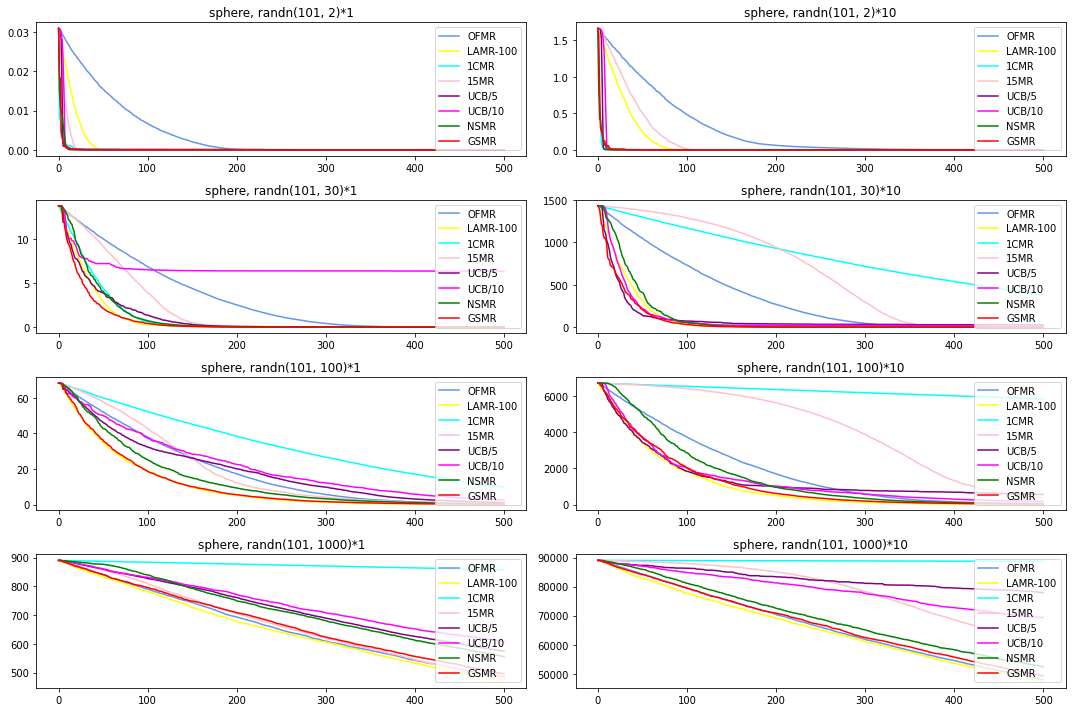

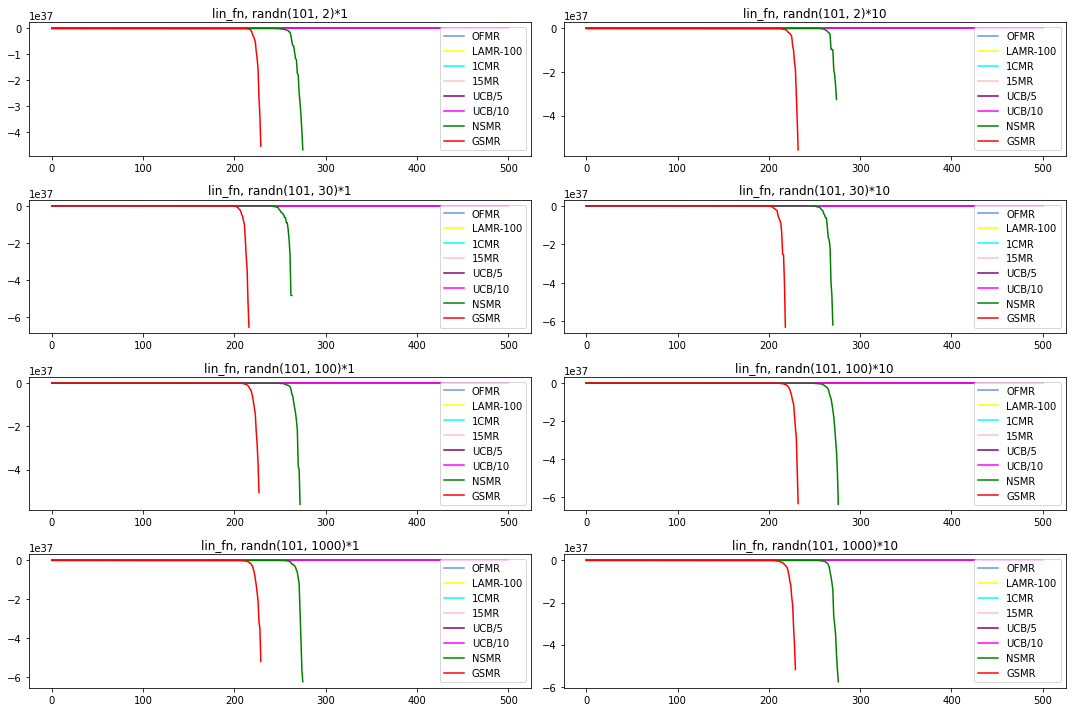

In [96]:
for optim_fn in data.coords['optim_fn']:
    plt.figure(figsize=(15, 10))
    i=1
    for n_dim in data.coords['n_dim']:
        for init_pop_var in data.coords['init_pop_var']:
            plt.subplot(len(data.coords['n_dim']), len(data.coords['init_pop_var']), i)
            i+=1
            for algo in data.coords['algo']:
                algo = str(algo.data)
                a = data.sel(algo=algo, optim_fn=optim_fn, 
                             n_dim=n_dim, init_pop_var=init_pop_var)
                b = torch.from_numpy(a.sel(fits_mrs='fits').data).float()
                viz.plot_mean_std(b, algo2label[algo], algo2color[algo], render_std=False, render_plots=False)
            plt.title(f'{optim_fn.item().__name__}, randn(101, {n_dim.item()})*{init_pop_var.item()}')
#             plt.gca().get_legend().remove()
    plt.tight_layout()
            



In [385]:
pop = torch.randn(11, 30)

pop = torch.randn(1, 30)
pop = pop/pop.norm(dim=-1)*.2
pop = pop.repeat(11, 30)

optim_fn = ackley
n_gen = 50
mrs = torch.logspace(-3, 0, 10)
ofmr, fits = optim.calc_ofmr(pop, optim_fn, n_gen, mrs, n_sample=5, tqdm=tqdm)

  0%|          | 0/10 [00:00<?, ?it/s]

In [386]:
x, xmut, fit_diff = get_mrs_fitness(pop, mrs, optim_fn, n_samples=60)
x.shape, xmut.shape, fit_diff.shape

(torch.Size([11, 900]),
 torch.Size([10, 60, 11, 900]),
 torch.Size([10, 60, 11]))

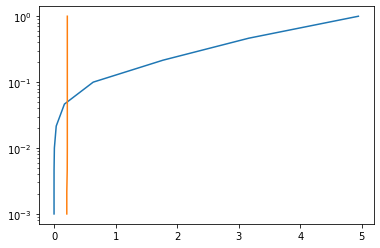

In [391]:
a = fit_diff.min(dim=-2).values.mean(dim=-1)
plt.plot(a, mrs)
a = fits.min(dim=-1).values[..., -1].mean(dim=-1)
plt.plot(a, mrs)
plt.yscale('log')

In [ ]:
def run_evolution_group(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., 
                       k=.5, k_elite=None,
                       tqdm=lambda x: x, k_mr=.5):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit, k=k, k_elite=k_elite)
        pop = calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mutpop), -1)
        data.append((bpop, bfit, mutpop, fit_mrs))
        fit_mrs_min = fit_mrs.min(dim=-1).values
        mutpop = calc_npop_log_uniform(mutpop, mr_mut, *calc_npop_idxs(fit_mrs_min, k=k_mr))
    data.append((pop, fit, mutpop, fit_mrs))
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]

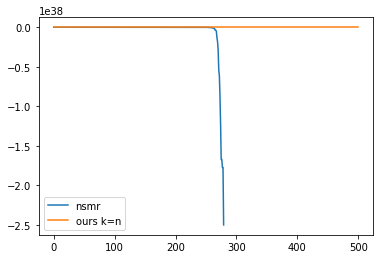

In [58]:
pop = torch.randn(101, 100)
optim_fn = lin_fn
n_gen = 500
# pops, fits = optim.run_evolution_base(pop, optim_fn, n_gen, mr=1e-2)
# plt.plot(fits.min(dim=-1).values, label='baseline')
# pops, fits, mrs, mr_fits = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=1, mr=1e-2)
# plt.plot(fits.min(dim=-1).values, label='ours k=1')
pops, fits, mrs = optim.run_evolution_ns(pop, optim_fn, n_gen)
plt.plot(fits.min(dim=-1).values, label='nsmr')
# plt.plot(mrs[..., 0].log().mean(dim=-1).exp(), label='nsmr')
pops, fits, mrs, mr_fits = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=100)
plt.plot(fits.min(dim=-1).values, label='ours k=n')
# plt.plot(mrs[..., 0].log().mean(dim=-1).exp(), label='ours k=n')
# plt.yscale('log')
plt.legend()

# Group size analysis

51 [ 1  2  5 10 25 50]


  0%|          | 0/6 [00:00<?, ?it/s]

101 [  1   2   4   5  10  20  25  50 100]


  0%|          | 0/9 [00:00<?, ?it/s]

201 [  1   2   4   5   8  10  20  25  40  50 100 200]


  0%|          | 0/12 [00:00<?, ?it/s]

401 [  1   2   4   5   8  10  16  20  25  40  50  80 100 200 400]


  0%|          | 0/15 [00:00<?, ?it/s]

601 [  1   2   3   4   5   6   8  10  12  15  20  24  25  30  40  50  60  75
 100 120 150 200 300 600]


  0%|          | 0/24 [00:00<?, ?it/s]

801 [  1   2   4   5   8  10  16  20  25  32  40  50  80 100 160 200 400 800]


  0%|          | 0/18 [00:00<?, ?it/s]

1001 [   1    2    4    5    8   10   20   25   40   50  100  125  200  250
  500 1000]


  0%|          | 0/16 [00:00<?, ?it/s]

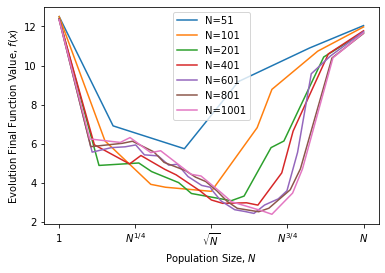

In [216]:
calc_factors = lambda x: np.array([i for i in range(1, x+1) if x%i==0])
optim_fn = ackley
n_gen = 500
n_seed = 5
n_dim = 100


# d = np.zeros((len(n_pops), len(optim_fns), len(n_dims), 
#                  len(init_pop_vars), n_seed, n_gen+1, 2))
# d = xr.DataArray(d, dims=('algo', 'optim_fn', 'n_dim', 
#                                 'init_pop_var', 'seed', 'gen', 'fits_mrs'),
#                     coords={'algo': algos, 
#                             'optim_fn': optim_fns,
#                             'n_dim': n_dims,
#                             'init_pop_var': init_pop_vars,
#                             'seed': list(range(n_seed)),
#                             'gen': list(range(n_gen+1)),
#                             'fits_mrs': ['fits', 'mrs'],
#                            })

n_pops = [51, 101, 201, 401, 601, 801, 1001]
# n_pops = [51]
for n_pop in n_pops:
    n_mutpops = calc_factors(n_pop-1)
    f = []
    print(n_pop, n_mutpops)
    for n_mutpop in tqdm(n_mutpops):
        for seed in range(n_seed):
            do_seed(seed+100)
            pop = torch.randn(n_pop, n_dim)*5
            pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
            f.append(fits)
    f = torch.stack(f).reshape(len(n_mutpops), n_seed, n_gen+1, n_pop)
    a = f.min(dim=-1).values[..., -1].T
    x = np.exp(np.log(n_mutpops)/np.log(np.max(n_mutpops)))
    plt.plot(x, a.mean(dim=0).numpy(), label=f'N={n_pop}')
ticks = np.e**np.linspace(0, 1, 5)
plt.xscale('log')
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(['$1$', '$N^{1/4}$', '$\sqrt{N}$', '$N^{3/4}$', '$N$'])
plt.minorticks_off()
plt.xlabel('Population Size, $N$')
plt.ylabel('Evolution Final Function Value, $f(x)$')
plt.legend()

51 [ 1  2  5 10 25 50]


  0%|          | 0/6 [00:00<?, ?it/s]

101 [  1   2   4   5  10  20  25  50 100]


  0%|          | 0/9 [00:00<?, ?it/s]

201 [  1   2   4   5   8  10  20  25  40  50 100 200]


  0%|          | 0/12 [00:00<?, ?it/s]

401 [  1   2   4   5   8  10  16  20  25  40  50  80 100 200 400]


  0%|          | 0/15 [00:00<?, ?it/s]

601 [  1   2   3   4   5   6   8  10  12  15  20  24  25  30  40  50  60  75
 100 120 150 200 300 600]


  0%|          | 0/24 [00:00<?, ?it/s]

801 [  1   2   4   5   8  10  16  20  25  32  40  50  80 100 160 200 400 800]


  0%|          | 0/18 [00:00<?, ?it/s]

1001 [   1    2    4    5    8   10   20   25   40   50  100  125  200  250
  500 1000]


  0%|          | 0/16 [00:00<?, ?it/s]

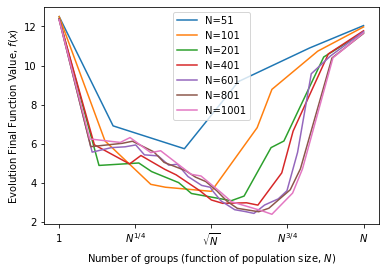

In [220]:
calc_factors = lambda x: np.array([i for i in range(1, x+1) if x%i==0])
optim_fn = ackley
n_gen = 500
n_seed = 5
n_dim = 100


# d = np.zeros((len(n_pops), len(optim_fns), len(n_dims), 
#                  len(init_pop_vars), n_seed, n_gen+1, 2))
# d = xr.DataArray(d, dims=('algo', 'optim_fn', 'n_dim', 
#                                 'init_pop_var', 'seed', 'gen', 'fits_mrs'),
#                     coords={'algo': algos, 
#                             'optim_fn': optim_fns,
#                             'n_dim': n_dims,
#                             'init_pop_var': init_pop_vars,
#                             'seed': list(range(n_seed)),
#                             'gen': list(range(n_gen+1)),
#                             'fits_mrs': ['fits', 'mrs'],
#                            })

n_pops = [51, 101, 201, 401, 601, 801, 1001]
# n_pops = [51]
for n_pop in n_pops:
    n_mutpops = calc_factors(n_pop-1)
    f = []
    print(n_pop, n_mutpops)
    for n_mutpop in tqdm(n_mutpops):
        for seed in range(n_seed):
            do_seed(seed+100)
            pop = torch.randn(n_pop, n_dim)*5
            pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
            f.append(fits)
    f = torch.stack(f).reshape(len(n_mutpops), n_seed, n_gen+1, n_pop)
    a = f.min(dim=-1).values[..., -1].T
    x = np.exp(np.log(n_mutpops)/np.log(np.max(n_mutpops)))
    plt.plot(x, a.mean(dim=0).numpy(), label=f'N={n_pop}')
ticks = np.e**np.linspace(0, 1, 5)
plt.xscale('log')
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(['$1$', '$N^{1/4}$', '$\sqrt{N}$', '$N^{3/4}$', '$N$'])
plt.minorticks_off()
plt.xlabel('Number of groups (function of population size, $N$)')
plt.ylabel('Evolution Final Function Value, $f(x)$')
plt.legend()

X comes from std normal with sigma
$$E[X^n] = \sigma^n (n-1)!$$
$$f(x+\epsilon) - f(x) = \delta(x, \sigma) = \frac{f'(x)}{1!}\epsilon+\frac{f''(x)}{2!}\epsilon^2+\frac{f'''(x)}{3!}\epsilon^3$$
$$E[\delta(x, \sigma)] = \frac{f'(x)}{1!}E[\epsilon]+\frac{f''(x)}{2!}E[\epsilon^2]+\frac{f'''(x)}{3!}E[\epsilon^3]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}E[\epsilon^n]$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\sigma^n (n-1)!$$
$$E[\delta(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$




$$f_{\Delta| X, \Sigma}(\delta| x, \sigma)$$
$$f_{\Delta, \Sigma}(\delta, \sigma)$$


$$\epsilon_i\sim N(0, \sigma) \qquad i=0,\dots,q$$
$$\delta_i(x, \sigma) = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_i(x, \sigma)] = \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n}\sigma^n$$
$$\min_i \delta_i(x, \sigma)] = 
\delta_\text{min}(x,\sigma) = 
\min_i \sum_{n=1}^\infty \frac{f^{(n)}(x)}{n!}\epsilon_i^n$$
$$E[\delta_\text{min}(x, \sigma)] = $$


$$P(\delta_\text{min} >a) = P(\delta_i > a \quad\forall i)=\Pi_i P(\delta_i>a)$$
$$F_{\delta_\text{min}}(a) = 1-\Pi_i P(\delta_i>a)$$
$$f_{\delta_\text{min}}(a) = -\frac{d}{da} \Pi_i P(\delta_i>a)$$
$$E[\delta_\text{min}] = -\int_{-\infty}^\infty a f_{\delta_\text{min}}(a) da =-\int_{-\infty}^\infty a \frac{d}{da} \left[\Pi_i P(\delta_i>a)\right] da$$

$$\int g(t) f'(t) dt = g(t)\int f'(t)dt - \int g'(t)\int f'(t)dt dt$$
$$\int g(t) f'(t) dt = a\int f'(a)da - \int \int f'(a)da da$$
$$\int g(t) f'(t) dt = af(a) - \int f(a) da$$




$$\int g(t) f'(t) dt = f'(t)\int g(t)dt - \int f''(t)\int g(t)dt dt$$

In [5]:
a = torch.randn(1000000, 1)
n = torch.arange(20)
an = a.pow(n)

In [6]:
def double_factorial(a):
    r = 1
    for i in range(2 if a%2==0 else 1, a+1, 2):
        r = r*i
    return r

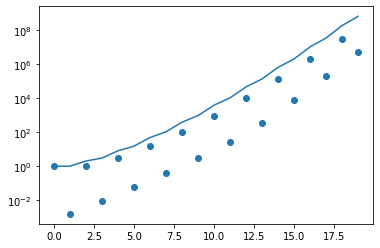

In [9]:
plt.scatter(n, an.mean(dim=0).abs().numpy())
plt.plot(n, [double_factorial(i) for i in n])
plt.yscale('log')
plt.savefig('temp300.png', dpi=300)
plt.savefig('temp30.png', dpi=30)